# Preparing the data

In [1]:
from io import open
import glob
import os

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

## Turn unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
    
print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Polish.txt', 'data/names/Czech.txt', 'data/names/Greek.txt', 'data/names/Japanese.txt', 'data/names/Arabic.txt', 'data/names/Dutch.txt', 'data/names/Chinese.txt', 'data/names/Spanish.txt', 'data/names/Italian.txt', 'data/names/French.txt', 'data/names/Korean.txt', 'data/names/Portuguese.txt', 'data/names/English.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Irish.txt', 'data/names/German.txt', 'data/names/Vietnamese.txt']
Slusarski


In [2]:
len(all_categories)

18

In [3]:
category_lines['Italian'][:5]

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

# String Names into Tensors

In [4]:
import torch

In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

In [6]:
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

print(letterToIndex('R'))
letterToTensor('R')

43


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [7]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
        
    return tensor

lineToTensor('Ronit').size()

torch.Size([5, 1, 57])

# Creating the Network

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [9]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8637, -2.7306, -2.8580, -2.9917, -2.9847, -2.9572, -2.7940, -2.8173,
         -2.8749, -3.0046, -2.9392, -2.8913, -2.8656, -2.9324, -2.9269, -2.9556,
         -2.8837, -2.8043]], grad_fn=<LogSoftmaxBackward0>)


# Training

In [10]:
output.topk(1)

torch.return_types.topk(
values=tensor([[-2.7306]], grad_fn=<TopkBackward0>),
indices=tensor([[1]]))

In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [12]:
categoryFromOutput(output)

('Czech', 1)

In [13]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, linen_tensor = randomTrainingExample()
    print('category =', category, '/line =', line)

category = Czech /line = Kesl
category = Vietnamese /line = Tieu
category = English /line = Stafford
category = Arabic /line = Attia
category = Italian /line = Brambani
category = Russian /line = Dyakov
category = Spanish /line = Suarez
category = Arabic /line = Toma
category = French /line = Janvier
category = Czech /line = Finferovy


# Training the Network

In [14]:
criterion = nn.NLLLoss()
learning_rate = 0.005

In [15]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)
    
    return output, loss.item()

In [16]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s-= m * 60
    return f"{m}, {s}"

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0, 8.350356101989746) 1.5893 Pho / Korean ✗ (Vietnamese)
10000 10% (0, 16.15129852294922) 2.4918 Houttum / Arabic ✗ (Dutch)
15000 15% (0, 23.604817628860474) 1.2006 Spellmeyer / German ✓
20000 20% (0, 33.02165174484253) 1.8043 Alves / Dutch ✗ (Portuguese)
25000 25% (0, 40.94591474533081) 0.8876 Juarez / Spanish ✓
30000 30% (0, 48.92563796043396) 4.0104 Castillion / Scottish ✗ (Spanish)
35000 35% (0, 56.646366119384766) 0.7902 Acquarone / Italian ✓
40000 40% (1, 4.364568710327148) 1.4027 Siu / Korean ✗ (Chinese)
45000 45% (1, 12.091976881027222) 1.3505 Mendelssohn / Dutch ✗ (German)
50000 50% (1, 19.94894790649414) 0.4591 Henriques / Portuguese ✓
55000 55% (1, 28.350200653076172) 2.4163 Nuremberg / Dutch ✗ (German)
60000 60% (1, 36.6600182056427) 0.0193 Awerichkin / Russian ✓
65000 65% (1, 45.2341148853302) 1.5512 Perugia / Portuguese ✗ (Italian)
70000 70% (1, 53.72792172431946) 0.1192 Egonidis / Greek ✓
75000 75% (2, 2.286712169647217) 0.0315 Nakada / Japanese ✓
80000 80% (2, 

# Plotting the results

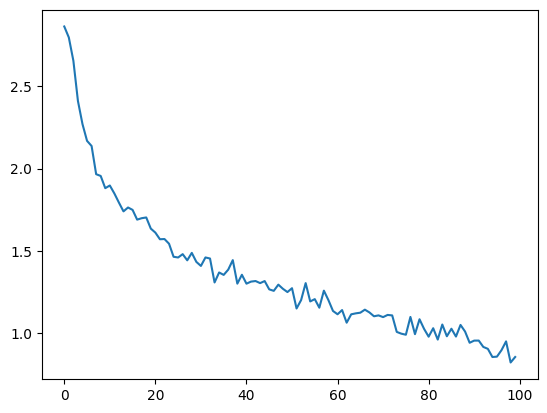

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluations

/tmp/ipykernel_53824/3585656379.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_53824/3585656379.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


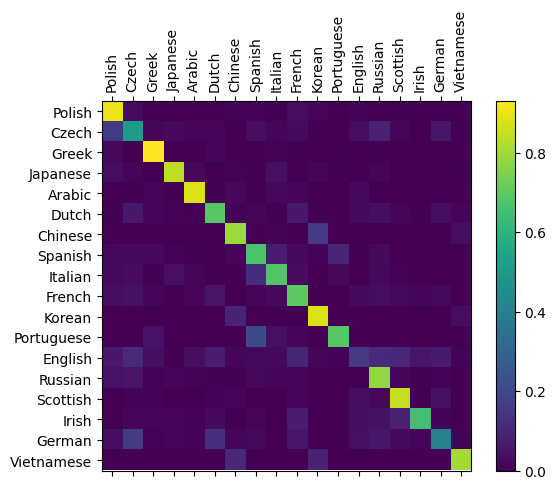

In [18]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# Running on the User Input

In [19]:
def predict(input_line, n_predictions=3):
    print(f'\n {input_line}')
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print(f'({-value:.2f} {all_categories[category_index]})')
            predictions.append([value, all_categories[category_index]])

In [20]:
predict("Yiruma")


 Yiruma
(0.10 Japanese)
(3.15 Arabic)
(3.63 Czech)
